In [2]:
# Importation

import pandas as pd
import keras
from keras import regularizers, layers, models, callbacks
import joblib

import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import numpy as np
import tensorflow as tf

2026-02-15 02:47:11.846843: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-15 02:47:11.855236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-15 02:47:12.247000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-15 02:47:13.822838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [3]:
df = pd.read_csv("../datas/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
df.tail()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0


In [5]:
df.shape

(10000, 14)

In [6]:
df.describe().round(2)

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00,10000.0,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,300.0,310.01,1538.78,39.99,107.95,0.03,0.00,0.01,0.01,0.01,0.00
std,2886.90,2.0,1.48,179.28,9.97,63.65,0.18,0.07,0.11,0.10,0.10,0.04
min,1.00,295.3,305.70,1168.00,3.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2500.75,298.3,308.80,1423.00,33.20,53.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,5000.50,300.1,310.10,1503.00,40.10,108.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,7500.25,301.5,311.10,1612.00,46.80,162.00,0.00,0.00,0.00,0.00,0.00,0.00
max,10000.00,304.5,313.80,2886.00,76.60,253.00,1.00,1.00,1.00,1.00,1.00,1.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [8]:
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

In [9]:
df.Type.value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [10]:
df["Machine failure"].value_counts(normalize=True)

Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64

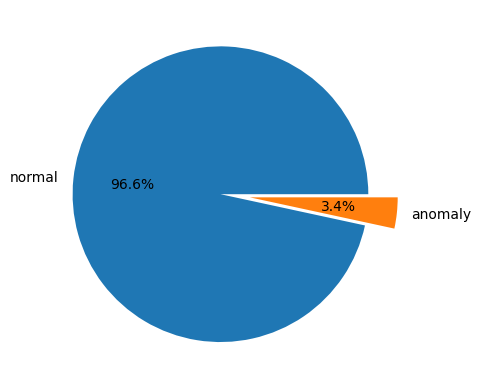

In [11]:
vc = df["Machine failure"].value_counts(ascending=False)

plt.pie(x=vc.values, labels=["normal", "anomaly"], explode=[0.0, 0.2], autopct="%1.1f%%")
plt.show()

On a peu de données anormales super.

In [12]:
def preprocess_data(df):
    df = df.set_index(keys="UDI", drop=True)
    df = df.drop(columns=["Product ID"])
    df = df.drop(columns=["TWF", "HDF", "PWF", "OSF", "RNF"]).copy()
    df = pd.get_dummies(
        df, columns=["Type"], prefix="Type", drop_first=True, dtype=int
    )
    return df

df_preprocessed = preprocess_data(df)
df_preprocessed.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M
UDI,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1
2,298.2,308.7,1408,46.3,3,0,1,0
3,298.1,308.5,1498,49.4,5,0,1,0
4,298.2,308.6,1433,39.5,7,0,1,0
5,298.2,308.7,1408,40.0,9,0,1,0


In [13]:
def build_features(df):
    df = df.copy()
    df["Power_kw"] = (df["Torque [Nm]"] * df["Rotational speed [rpm]"]) / 9550
    df["Temp_diff"] = df["Process temperature [K]"] - df["Air temperature [K]"]
    df["Speed_torque_ratio"] = df["Rotational speed [rpm]"] / (df["Torque [Nm]"] + 1)
    max_wear = df["Tool wear [min]"].max()
    df["Wear_level"] = pd.cut(
        df["Tool wear [min]"],
        bins=[0, 80, 160, max_wear + 1],
        labels=[0, 1, 2],
        include_lowest=True,
    )
    df["Wear_level"] = (
        pd.to_numeric(df["Wear_level"], errors="coerce").fillna(0).astype(int)
    )
    df["High_wear"] = (df["Tool wear [min]"] > 200).astype(int)
    df["Thermal_load"] = df["Temp_diff"] * df["Power_kw"]
    df["Mechanical_stress"] = df["Torque [Nm]"] * (1 + df["Tool wear [min]"] / 250)

    return df

df_featured = build_features(df_preprocessed)
df_featured.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M,Power_kw,Temp_diff,Speed_torque_ratio,Wear_level,High_wear,Thermal_load,Mechanical_stress
UDI,,,,,,,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1,6.951079,10.5,35.410959,0,0,72.986325,42.8000
2,298.2,308.7,1408,46.3,3,0,1,0,6.826220,10.5,29.767442,0,0,71.675309,46.8556
3,298.1,308.5,1498,49.4,5,0,1,0,7.748817,10.4,29.722222,0,0,80.587694,50.3880
4,298.2,308.6,1433,39.5,7,0,1,0,5.927068,10.4,35.382716,0,0,61.641508,40.6060
5,298.2,308.7,1408,40.0,9,0,1,0,5.897382,10.5,34.341463,0,0,61.922513,41.4400


In [14]:
df_featured.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'Type_L', 'Type_M', 'Power_kw', 'Temp_diff',
       'Speed_torque_ratio', 'Wear_level', 'High_wear', 'Thermal_load',
       'Mechanical_stress'],
      dtype='object')

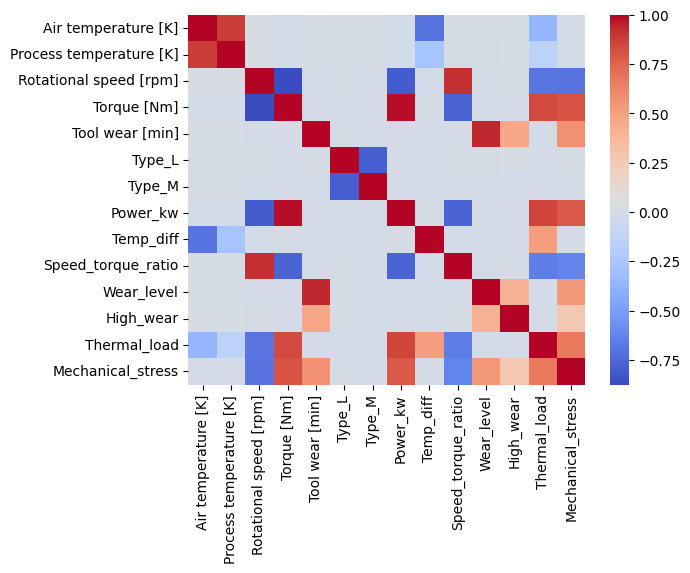

In [19]:
corr = df_featured.drop(columns=["Machine failure"]).corr(method="pearson")

# plt.figure(figsize=(10, 10))

sns.heatmap(corr, cmap="coolwarm", annot=False)

plt.show()

In [15]:
CORRELATION_THRESHOLD = 0.9
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(key=lambda x: x.abs(), ascending=False)
    .reset_index()
)

corr_pairs.columns = ["var1", "var2", "correlation"]
strong_corr_pairs = corr_pairs[corr_pairs["correlation"] > CORRELATION_THRESHOLD]
strong_corr_pairs.head()

,var1,var2,correlation
0,Torque [Nm],Power_kw,0.978828
1,Tool wear [min],Wear_level,0.936736
2,Rotational speed [rpm],Speed_torque_ratio,0.915514


In [16]:
features_to_drop = []
for _, row in strong_corr_pairs.iterrows():
    var1, var2 = row["var1"], row["var2"]
    if df_featured[var1].var() < df_featured[var2].var():
        features_to_drop.append(var1)
        print("Should drop", var1)
    else:
        features_to_drop.append(var2)
        print("Should drop", var2)

df_cleaned = df_featured.drop(columns=features_to_drop)

df_cleaned.head()

Should drop Power_kw
Should drop Wear_level
Should drop Speed_torque_ratio


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M,Temp_diff,High_wear,Thermal_load,Mechanical_stress
UDI,,,,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1,10.5,0,72.986325,42.8000
2,298.2,308.7,1408,46.3,3,0,1,0,10.5,0,71.675309,46.8556
3,298.1,308.5,1498,49.4,5,0,1,0,10.4,0,80.587694,50.3880
4,298.2,308.6,1433,39.5,7,0,1,0,10.4,0,61.641508,40.6060
5,298.2,308.7,1408,40.0,9,0,1,0,10.5,0,61.922513,41.4400


In [17]:
X = df_cleaned.drop(columns=["Machine failure"])
y = df_cleaned["Machine failure"]

In [18]:
len(X.columns)

11

In [19]:
# # Créer un sous-plot pour chaque colonne
# fig, axes = plt.subplots(
#     nrows=len(X.columns),
#     ncols=1,
#     figsize=(12, 4 * len(X.columns)),
#     sharex=True,
# )

# for i, col in enumerate(X.columns):
#     axes[i].plot(X.index, X[col], label="Valeurs normales", alpha=0.7)
#     axes[i].scatter(
#         X[y == 1].index,
#         X[y == 1][col],
#         color="red",
#         label="Anomalies",
#     )
#     axes[i].set_title(f"Série temporelle de {col}")
#     axes[i].legend()

# plt.tight_layout()
# plt.show()

In [20]:
n_total = len(X)

n_train = int(0.8 * n_total)
n_val = int(0.15 * n_total)

X_train_full = X[:n_train]
y_train_full = y[:n_train]

X_val_full = X[n_train : n_train + n_val]
y_val_full = y[n_train : n_train + n_val]

X_test = X[n_train + n_val :]
y_test = y[n_train + n_val :]

In [21]:
X_train = X_train_full[y_train_full == 0]
X_val = X_val_full[y_val_full == 0]

In [22]:
X_train.shape

(7700, 11)

In [23]:
X_val.shape

(1474, 11)

In [24]:
y_test.value_counts()

Machine failure
0    487
1     13
Name: count, dtype: int64

In [25]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train

array([[0.30434783, 0.35802469, 0.2508186 , ..., 0.        , 0.58900607,
        0.31620015],
       [0.31521739, 0.37037037, 0.15717092, ..., 0.        , 0.57142537,
        0.35938378],
       [0.30434783, 0.34567901, 0.21611002, ..., 0.        , 0.69094031,
        0.39699644],
       ...,
       [0.61956522, 0.80246914, 0.2167649 , ..., 0.        , 0.588607  ,
        0.54981515],
       [0.60869565, 0.79012346, 0.12508186, ..., 0.        , 0.71523678,
        0.73245651],
       [0.60869565, 0.79012346, 0.2940406 , ..., 0.        , 0.39860256,
        0.38596521]], shape=(7700, 11))

In [26]:
def create_sequences(X, timesteps):
    sequences = []
    for i in range(len(X) - timesteps + 1):
        sequences.append(X[i : i + timesteps])
    return np.array(sequences)

In [27]:
# def build_models(timesteps, n_features, latent_dim=16):

#     # ========= ENCODER =========
#     encoder_inputs = keras.Input(shape=(timesteps, n_features))
#     x = layers.GaussianNoise(0.1)(encoder_inputs)

#     x = layers.LSTM(32, return_sequences=True)(encoder_inputs)
#     x = layers.GaussianDropout(0.2)(x)
#     x = layers.LSTM(latent_dim)(x)

#     latent = layers.Dense(latent_dim, name="latent_vector")(x)

#     encoder = keras.Model(encoder_inputs, latent, name="encoder")

#     # ========= DECODER =========
#     latent_inputs = keras.Input(shape=(latent_dim,))

#     x = layers.RepeatVector(timesteps)(latent_inputs)
#     x = layers.LSTM(latent_dim, return_sequences=True)(x)
#     x = layers.GaussianDropout(0.2)(x)
#     x = layers.LSTM(32, return_sequences=True)(x)

#     outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

#     decoder = keras.Model(latent_inputs, outputs, name="decoder")

#     # ========= AUTOENCODER =========
#     autoencoder_outputs = decoder(encoder(encoder_inputs))

#     autoencoder = keras.Model(encoder_inputs, autoencoder_outputs, name="autoencoder")

#     autoencoder.compile(
#         optimizer="adam",
#         loss="mse"
#     )

#     return encoder, decoder, autoencoder

In [28]:
import logging

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

def build_models(timesteps, n_features, latent_dim=16):

    logger.info(
        f"Building models - Timesteps: {timesteps}, Features: {n_features}, Latent dim: {latent_dim}"
    )

    # ========= ENCODER =========

    encoder_inputs = keras.Input(shape=(timesteps, n_features))

    x = layers.GaussianNoise(0.1)(encoder_inputs)

    # Feature extraction (temporal local patterns)
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu")(x)

    x = layers.GaussianDropout(0.2)(x)

    # Sequence modeling
    x = layers.GRU(32, return_sequences=True)(x)
    x = layers.GRU(latent_dim)(x)

    latent = layers.Dense(latent_dim, name="latent_vector")(x)

    encoder = keras.Model(encoder_inputs, latent, name="encoder")

    logger.info(f"Encoder built - Params: {encoder.count_params():,}")

    # ========= DECODER =========

    latent_inputs = keras.Input(shape=(latent_dim,))

    x = layers.RepeatVector(timesteps)(latent_inputs)

    x = layers.GRU(latent_dim, return_sequences=True)(x)
    x = layers.GaussianDropout(0.2)(x)
    x = layers.GRU(32, return_sequences=True)(x)

    # Reconstruction head
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same", activation="relu")(x)

    outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    logger.info(f"Decoder built - Params: {decoder.count_params():,}")

    # ========= AUTOENCODER =========

    autoencoder_outputs = decoder(encoder(encoder_inputs))

    autoencoder = keras.Model(encoder_inputs, autoencoder_outputs, name="autoencoder")

    autoencoder.compile(optimizer="adam", loss="mse")

    logger.info(f"Autoencoder compiled - Total params: {autoencoder.count_params():,}")

    return encoder, decoder, autoencoder

In [29]:
TIMESTEPS = 1

X_train_seq = create_sequences(X_train, timesteps=TIMESTEPS)
X_val_seq = create_sequences(X_val, timesteps=TIMESTEPS)


encoder, decoder, autoencoder = build_models(
    timesteps=TIMESTEPS, n_features=X_train_seq.shape[2]
)

autoencoder.summary()
encoder.summary()

2026-02-15 01:24:06 - INFO - Building models - Timesteps: 1, Features: 11, Latent dim: 16
2026-02-15 01:24:06.118126: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2026-02-15 01:24:06 - INFO - Encoder built - Params: 10,096
2026-02-15 01:24:06 - INFO - Decoder built - Params: 9,899
2026-02-15 01:24:06 - INFO - Autoencoder compiled - Total params: 19,995


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 11)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │        10,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1, 11)          │         9,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,995 (78.11 KB)

 Trainable params: 19,995 (78.11 KB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 11)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 1, 11)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 32)          │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_dropout                │ (None, 1, 32)          │             0 │
│ (GaussianDropout)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1, 32)          │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,096 (39.44 KB)

 Trainable params: 10,096 (39.44 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",  # surveille la loss validation
    patience=20,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # surveille la loss validation
    factor=0.5,  # multiplie le learning rate par 0.5
    patience=5,  # attend 5 epochs sans amélioration
    min_lr=1e-6,  # learning rate minimum
    verbose=1,
)

history = autoencoder.fit(
    X_train_seq,
    X_train_seq,  # autoencoder -> target = input
    validation_data=(X_val_seq, X_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[
        early_stopping,
        reduce_lr
    ],
    shuffle=False
)

Epoch 1/100
  1/241 ━━━━━━━━━━━━━━━━━━━━ 18:55 5s/step - loss: 0.2048

2026-02-15 01:24:10.945783: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0643 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 2/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0226 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0192 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0172 - val_loss: 0.0241 - learning_rate: 0.0010
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 9/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 10/100


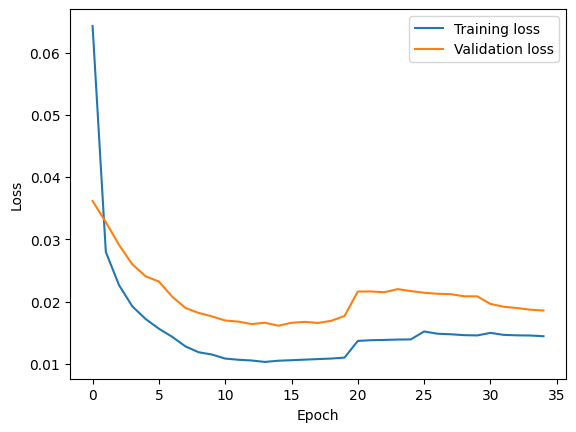

In [31]:
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [32]:
# Reconstruction des séquences
X_test_seq = create_sequences(X_test, timesteps=TIMESTEPS)
X_test_reconstructed = autoencoder.predict(X_test_seq)

reconstruction_error = np.mean(np.square(X_test_seq - X_test_reconstructed))

print("Reconstruction error (MSE) sur le test :", reconstruction_error)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Reconstruction error (MSE) sur le test : 0.010743968934456085


In [33]:
autoencoder.save("../artifacts/autoencoder.keras")
encoder.save("../artifacts/encoder.keras")

In [34]:
y_test_seq = []
for i in range(len(y_test) - TIMESTEPS + 1):
    sequence_labels = y_test[i : i + TIMESTEPS]
    y_test_seq.append(1 if np.any(sequence_labels == 1) else 0)
y_test_seq = np.array(y_test_seq)
print(y_test_seq)

# Maintenant filtrer directement sur les séquences
X_test_seq_normal = X_test_seq[y_test_seq == 0]
X_test_reconstructed_normal = autoencoder.predict(X_test_seq_normal)

normal_error = np.mean(
    np.square(X_test_seq_normal - X_test_reconstructed_normal), axis=(1, 2)
)
print("MSE normal :", np.mean(normal_error))

# Pour les anomalies
X_test_seq_anomaly = X_test_seq[y_test_seq == 1]
X_test_reconstructed_anomaly = autoencoder.predict(X_test_seq_anomaly)

anomaly_error = np.mean(
    np.square(X_test_seq_anomaly - X_test_reconstructed_anomaly), axis=(1, 2)
)
print("MSE anomaly :", np.mean(anomaly_error))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

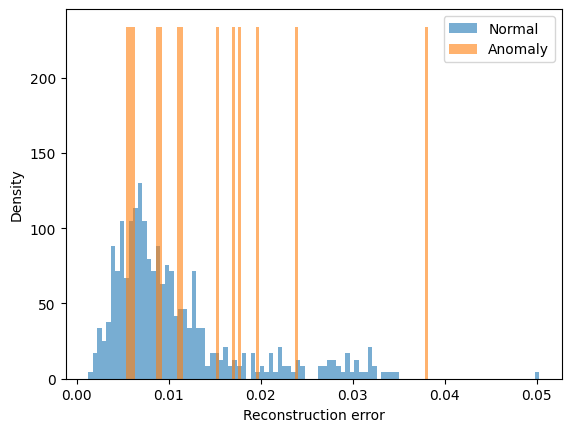

In [35]:
plt.figure()
plt.hist(normal_error, bins=100, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_error, bins=100, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np


def optimize_threshold_with_sequences(autoencoder, X_test, y_test, timesteps):
    # 1. Créer les séquences pour X_test et y_test
    X_test_seq = create_sequences(X_test, timesteps)

    # Labelliser les séquences : 1 si au moins une anomalie dans la séquence
    y_test_seq = []
    for i in range(len(y_test) - timesteps + 1):
        sequence_labels = y_test[i : i + timesteps]
        y_test_seq.append(1 if np.any(sequence_labels == 1) else 0)
    y_test_seq = np.array(y_test_seq)

    # 2. Prédire les reconstructions pour TOUTES les séquences
    reconstructions = autoencoder.predict(X_test_seq)

    # 3. Calculer le MSE par séquence
    mse = np.mean(np.square(X_test_seq - reconstructions), axis=(1, 2))

    # 4. Séparer les erreurs pour les séquences normales et anormales
    mse_normal = mse[y_test_seq == 0]
    mse_anomaly = mse[y_test_seq == 1]

    print(f"MSE moyen (normal): {np.mean(mse_normal):.4f}")
    print(f"MSE moyen (anomaly): {np.mean(mse_anomaly):.4f}")

    # 5. Tester différents seuils pour maximiser le F1-score
    thresholds = np.linspace(min(mse_normal), max(mse_anomaly), 100)
    best_f1 = 0
    best_seuil = 0
    best_precision = 0
    best_recall = 0
    best_accuracy = 0

    for seuil in thresholds:
        pred = (mse > seuil).astype(int)
        f1 = f1_score(y_test_seq, pred)
        accuracy = accuracy_score(y_test_seq, pred)
        if f1 > best_f1:
            best_f1 = f1
            best_seuil = seuil
            best_precision = precision_score(y_test_seq, pred)
            best_recall = recall_score(y_test_seq, pred)
            best_accuracy = accuracy

    print(f"\nMeilleur seuil (F1={best_f1:.3f}): {best_seuil:.4f}")
    print(
        f"Précision: {best_precision:.3f}, Rappel: {best_recall:.3f}, Accuracy: {best_accuracy:.3f}"
    )

    return best_seuil

In [37]:
seuil = optimize_threshold_with_sequences(autoencoder=autoencoder, X_test=X_test, y_test=y_test, timesteps=TIMESTEPS)
print(seuil)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE moyen (normal): 0.0106
MSE moyen (anomaly): 0.0146

Meilleur seuil (F1=0.133): 0.0349
Précision: 0.500, Rappel: 0.077, Accuracy: 0.974
0.034875952572591136


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


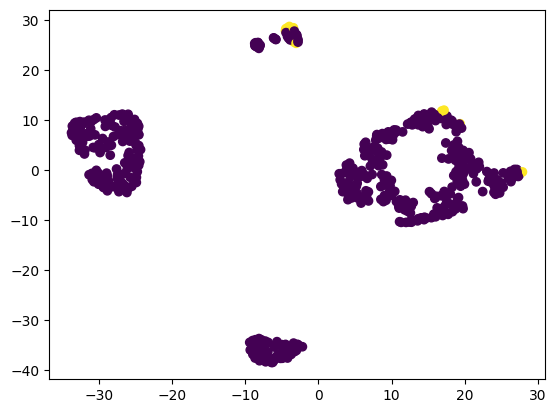

In [38]:
from sklearn.manifold import TSNE

latent_vectors = encoder.predict(X_test_seq)
tsne = TSNE(n_components=2)
latent_2d = tsne.fit_transform(latent_vectors)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test_seq)
plt.show()

In [39]:
# import pandas as pd
# import numpy as np

# n = 5000
# np.random.seed(42)

# # Créer des Product ID fictifs
# product_ids = [f"P{i:05d}" for i in range(1, 101)]  # 100 produits différents

# # Générer les données synthétiques
# data = {
#     "UDI": np.arange(1, n + 1),
#     "Product ID": np.random.choice(product_ids, size=n),
#     "Type": np.random.choice(["L", "M", "H"], size=n),
#     "Air temperature [K]": np.clip(
#         np.random.normal(loc=300.0, scale=2.0, size=n), 295.3, 304.5
#     ),
#     "Process temperature [K]": np.clip(
#         np.random.normal(loc=310.01, scale=1.48, size=n), 305.7, 313.8
#     ),
#     "Rotational speed [rpm]": np.clip(
#         np.random.normal(loc=1538.78, scale=179.28, size=n), 1168, 2886
#     ).astype(int),
#     "Torque [Nm]": np.clip(np.random.normal(loc=39.99, scale=9.97, size=n), 3.8, 76.6),
#     "Tool wear [min]": np.clip(
#         np.random.normal(loc=107.95, scale=63.65, size=n), 0, 253
#     ).astype(int),
#     "Machine failure": np.random.choice([0, 1], size=n, p=[0.97, 0.03]),
#     "TWF": np.random.choice([0, 1], size=n, p=[0.93, 0.07]),
#     "HDF": np.random.choice([0, 1], size=n, p=[0.89, 0.11]),
#     "PWF": np.random.choice([0, 1], size=n, p=[0.90, 0.10]),
#     "OSF": np.random.choice([0, 1], size=n, p=[0.90, 0.10]),
#     "RNF": np.random.choice([0, 1], size=n, p=[0.96, 0.04]),
# }

# df_synthetic = pd.DataFrame(data)

# # Sauvegarder en CSV
# csv_path = "../datas/test.csv"
# df_synthetic.to_csv(csv_path, index=False)

# print(f"Dataset sauvegardé dans {csv_path}")